# SVM

### Ucitavanje biblioteka

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVR

### Ucitavanje skupa podataka

In [152]:
data = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ciscenje podataka

In [153]:
data = data.drop(['Timestamp', 'Open', 'High', 'Low', 'Volume_(BTC)','Volume_(Currency)','Weighted_Price'], axis=1)
data = data.dropna()

In [86]:
data.head()

,Close
0,4.39
478,4.39
547,4.57
548,4.58
1224,4.58


In [87]:
data.tail()

,Close
4857372,58686.00
4857373,58685.81
4857374,58723.84
4857375,58760.59
4857376,58778.18


### Vizuelni prikaz podataka

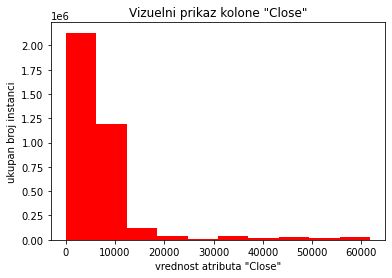

In [88]:
plt.title('Vizuelni prikaz kolone "Close"')
plt.hist(data['Close'],color='red')
plt.xlabel('vrednost atributa "Close"')
plt.ylabel('ukupan broj instanci')
plt.show()

In [89]:
# provera
np.max(data['Close']), data.shape

(61781.8, (3613769, 1))

### Definicije funkcija

In [91]:
# Funkcija koja odredjuje skupove X i y (y je target promenljiva)
# na osnovu datog skupa podataka i dana za predvidjanje, tako sto
# kreira novu kolonu 'Predictions' u koju upisuje predvidjene vrednosti

def determine_x_and_y(days_to_predict, data):
    
    data['Predictions'] = data[['Close']].shift(-days_to_predict)

    last_instance = len(data) - days_to_predict

    X = data.drop(['Predictions'], 1)
    X = np.array(X)
    X = X[: last_instance]

    y = data['Predictions']
    y = np.array(y)
    y = y[: last_instance]
    
    return X, y

In [92]:
# Funkcija koja redukuje skupove X i y (y je target promenljiva)
# u skladu sa vrednoscu parametra reduce_number
# radi brzeg izvrsavanja algoritma SVM

def reduce_datasets(X, y, reduce_number = 50000):
    
    X = X[-reduce_number:]
    y = y[-reduce_number:]
    
    return X, y

In [93]:
# Funkcija koja vrsi podelu skupa podataka
# na skupove za treniranje i testiranje

def split_data(days, data, reduce_number, test_size):
    
    X, y = determine_x_and_y(days, data)
    X, y = reduce_datasets(X, y, reduce_number = reduce_number)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 101) # TODO stratify = y
        
    return X, y, X_train, X_test, y_train, y_test

In [94]:
# Funkcija koja kreira model, trenira ga
# i izracunava skor (tacnost) modela

def calculate_score(X_train, y_train, X_, y_):
    
    # kreiranje Support Vector Machine (SVM) modela koristeci radial basis funkciju
    svr_rbf = SVR(kernel = 'rbf', gamma = 0.00001)

    # treniranje modela
    svr_rbf.fit(X_train, y_train)
    
    # racunanje tacnosti modela
    svr_rbf_score = svr_rbf.score(X_, y_)
    
    return svr_rbf_score, svr_rbf

In [95]:
# Funkcija koja racuna tacnost modela
# za date test podatke, za svaki dan
# iz date liste dana za predvidjanje

def get_scores(list_of_days_to_predict, data, reduce_number = 50000, test_size = 0.3):
    
    scores = []
    
    for days in list_of_days_to_predict:
        X, y, X_train, X_test, y_train, y_test = split_data(days, data, reduce_number, test_size)
        score, svr_rbf = calculate_score(X_train, y_train, X_test, y_test)
        scores.append(score)
        
    return scores

### Izracunavanje tacnosti modela

In [96]:
# Zadavanje broja dana za predvidjanje,
# poziv funkcije get_scores()
# i ispis rezultata

list_of_days_to_predict = [1, 10, 20, 30, 90, 365]

all_scores = get_scores(list_of_days_to_predict, data, reduce_number = 50000, test_size = 0.3)

print(all_scores)

[0.35316775193456484, 0.3572938211552349, 0.35981040510377005, 0.36114608876431364, 0.36263926289510584, 0.35685641811648394]


### Vizuelni prikaz tacnosti modela

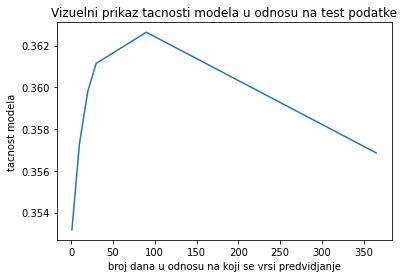

In [97]:
plt.title('Vizuelni prikaz tacnosti modela u odnosu na test podatke')
plt.xlabel('broj dana u odnosu na koji se vrsi predvidjanje')
plt.ylabel('tacnost modela')
plt.plot([1, 10, 20, 30, 90, 365], all_scores)
plt.show()

### Predvidjanje vrednosti nad skupom za testiranje i ispis

In [99]:
n = list_of_days_to_predict[3] # za primer je uzet jedan element iz liste dana za predvidjanje

X, y, X_train, X_test, y_train, y_test = split_data(days = n, data = data, reduce_number = 50000, test_size = 0.3)
score_value, model = calculate_score(X_train, y_train, X_test, y_test)

model_predictions = model.predict(X_test)
print('\nmodel predictions:\n', model_predictions)
print('\ny_test:\n', y_test)


model predictions:
 [53552.45365064 52974.79662486 55592.65416903 ... 54910.58091705
 53232.03849849 52900.30291829]

y_test:
 [52168.12 50943.69 55874.57 ... 60034.39 45680.76 50974.95]


### Predvidjanje vrednosti za skup od poslednjih n instanci skupa podataka za koje je 'Predictions' = NaN

In [154]:
# Ukoliko je funkcija determine_x_and_y(days_to_predict, data) vec izvrsena,
# naredne dve linije koda ne treba izvrsavati

data['Predictions'] = data[['Close']].shift(-n)
data

,Close,Predictions
0,4.39,6.15
478,4.39,6.19
547,4.57,6.23
548,4.58,6.25
1224,4.58,6.46
...,...,...
4857372,58686.00,NaN
4857373,58685.81,NaN
4857374,58723.84,NaN
4857375,58760.59,NaN


In [155]:
# Kreiranje niza koji sadrzi poslednjih n dana
# (redova/instanci) iz originalnog skupa podataka

predictions_array = np.array(data.drop(['Predictions'],1))[-n:]
print(predictions_array)

[[58744.88]
 [58736.03]
 [58755.94]
 [58704.68]
 [58728.74]
 [58669.75]
 [58628.24]
 [58642.47]
 [58600.2 ]
 [58616.45]
 [58616.33]
 [58616.33]
 [58620.59]
 [58608.38]
 [58600.  ]
 [58600.  ]
 [58666.54]
 [58702.79]
 [58677.7 ]
 [58644.13]
 [58689.44]
 [58699.9 ]
 [58698.5 ]
 [58739.95]
 [58714.31]
 [58686.  ]
 [58685.81]
 [58723.84]
 [58760.59]
 [58778.18]]


In [158]:
# Ispis stvarne vrednosti Bitcoin-a u poslednjih n dana
# Predvidjene vrednosti su NaN

print(data.tail(n))

            Close  Predictions
4857346  58744.88          NaN
4857347  58736.03          NaN
4857348  58755.94          NaN
4857349  58704.68          NaN
4857350  58728.74          NaN
4857351  58669.75          NaN
4857352  58628.24          NaN
4857353  58642.47          NaN
4857354  58600.20          NaN
4857355  58616.45          NaN
4857356  58616.33          NaN
4857357  58616.33          NaN
4857358  58620.59          NaN
4857359  58608.38          NaN
4857360  58600.00          NaN
4857361  58600.00          NaN
4857362  58666.54          NaN
4857363  58702.79          NaN
4857364  58677.70          NaN
4857365  58644.13          NaN
4857366  58689.44          NaN
4857367  58699.90          NaN
4857369  58698.50          NaN
4857370  58739.95          NaN
4857371  58714.31          NaN
4857372  58686.00          NaN
4857373  58685.81          NaN
4857374  58723.84          NaN
4857375  58760.59          NaN
4857376  58778.18          NaN


In [159]:
# Predvidjanje i ispis predvidjenih vrednosti Bitcoin-a u poslednjih n dana

svm_n_last_day_predictions = model.predict(predictions_array)
print(svm_n_last_day_predictions)

[55816.39402194 55818.90037329 55812.43042685 55823.17302383
 55820.52713751 55820.09186161 55807.39352025 55812.70728062
 55794.55280196 55802.34183913 55802.2876629  55802.2876629
 55804.17783461 55798.58383216 55794.45165121 55794.45165121
 55819.43295038 55823.20925459 55821.46406932 55813.26630164
 55822.78504168 55823.21784677 55823.20181545 55817.8626078
 55822.60607434 55822.48753426 55822.46891055 55821.40144041
 55810.4854371  55801.62433155]


In [160]:
# Kreiranje DataFrame-a 'predictions_df' i
# dodavanje predvidjenih vrednosti u 'predictions_df'

predictions_df = pd.DataFrame(data['Close'][-n:], columns = ['Close'])
predictions_df['Predictions'] = svm_n_last_day_predictions
predictions_df

,Close,Predictions
4857346,58744.88,55816.394022
4857347,58736.03,55818.900373
4857348,58755.94,55812.430427
4857349,58704.68,55823.173024
4857350,58728.74,55820.527138
4857351,58669.75,55820.091862
4857352,58628.24,55807.393520
4857353,58642.47,55812.707281
4857354,58600.20,55794.552802
4857355,58616.45,55802.341839


In [165]:
# Uklanjanje NaN vrednosti (nastale usled siftovanja)
# iz originalnog DataFrame-a

data = data.dropna()
data

,Close,Predictions
0,4.39,6.15
478,4.39,6.19
547,4.57,6.23
548,4.58,6.25
1224,4.58,6.46
...,...,...
4857341,58673.85,58686.00
4857342,58692.46,58685.81
4857343,58730.96,58723.84
4857344,58721.65,58760.59


In [167]:
# Nadovezivanje kreiranog DataFrame-a na originalni DataFrame
# (dodavanje predvidjenih vrednosti u originalni DataFrame)

data = data.append(predictions_df)
data

,Close,Predictions
0,4.39,6.150000
478,4.39,6.190000
547,4.57,6.230000
548,4.58,6.250000
1224,4.58,6.460000
...,...,...
4857372,58686.00,55822.487534
4857373,58685.81,55822.468911
4857374,58723.84,55821.401440
4857375,58760.59,55810.485437


In [169]:
# Provera

data.tail(n)

,Close,Predictions
4857346,58744.88,55816.394022
4857347,58736.03,55818.900373
4857348,58755.94,55812.430427
4857349,58704.68,55823.173024
4857350,58728.74,55820.527138
4857351,58669.75,55820.091862
4857352,58628.24,55807.393520
4857353,58642.47,55812.707281
4857354,58600.20,55794.552802
4857355,58616.45,55802.341839
